# Import Libraries

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.patches import Rectangle
import os
from skimage import io
from skimage import exposure
import natsort as ns
import multiprocessing
from tqdm import tqdm_notebook
from skimage.util import *
import sklearn

# Load Images

In [ ]:
path = os.getcwd()

im_dir = r''+ path + '/Zurich_dataset/images_tif/'
gt_dir = r''+ path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

def im_load(path, max_size = 600): # for now, only return highest [max_size] pixels, multiple of patch_size
    """load a TIF image"""
    image = np.asarray(io.imread(path)).astype(float)
    #print(image.shape)
    return np.asarray(image[:max_size,:max_size,:])


def get_im_patches(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [ ]:
max_size = 512
imgs = np.asarray([im_load(im_dir + im_name, max_size = max_size) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name, max_size = max_size) for gt_name in gt_names])
print(imgs.shape)

In [ ]:
# Loaded a set of images
def imgs_stretch_eq(imgs):
    imgs_stretch, imgs_eq = [], []
    for im in imgs:
        # Contrast stretching
        p2, p98 = np.percentile(im, (2, 98))
        img_stretch = im.copy()
        img_eq = im.copy()
        for band in range(im.shape[-1]):
            img_stretch[:,:,band] = exposure.rescale_intensity(im[:,:,band], in_range=(p2, p98))
            img_eq[:,:,band] = exposure.equalize_hist(img_stretch[:,:,band])
        
        # append images
        imgs_stretch.append(img_stretch)
        imgs_eq.append(img_eq)
        
    # convert to np arrays
    imgs_stretch = np.asarray(imgs_stretch)
    imgs_eq = np.asarray(imgs_eq)
    return imgs_stretch, imgs_eq 

imgs_stretch, imgs_eq = imgs_stretch_eq(imgs)

In [ ]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 1
alpha=.6
overlay = imgs_eq[i][:,:,:3]*alpha+gt[i]/255*(1-alpha)

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs_eq[i][:,:,:3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
axes[0].set_title("Stretched image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
plt.show()

In [ ]:
imgs = imgs_eq # continue using stretched image

In [ ]:
print(np.shape(imgs))
print(np.shape(gt))

## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [ ]:
# get label corresponding to each color
from collections import OrderedDict

legend = OrderedDict((('Background',[255, 255, 255]),
          ('Roads',[0, 0, 0]),
          ('Buildings',[100, 100, 100]),
          ('Trees',[0, 125, 0]),
          ('Grass',[0, 255, 0]),
          ('Bare Soil',[150, 80, 0]),
          ('Water',[0, 0, 150]),
          ('Railways',[255, 255, 0]),
          ('Swimming Pools',[150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

In [ ]:
def gt_color_to_label(gt, maj = False):
    """
    Transform a set of GT image in value range [0, 255] of shape (n_images, width, height, 3) 
    to a set of GT labels of shape (n_images, width, height)
    """
    
    # sum of distinct color values
    gt_new = np.zeros(np.asarray(gt).shape[:-1])

    # replace colors by new values
    for i in range(len(colors)):
        gt_new[np.all(gt==colors[i],axis=-1)] = i #np.argsort(colors)[i]    
        
    if maj:
        # return only majority label for each patch
        gt_maj_label = []
        for i in range(len(gt)):
            counts = np.bincount(gt_new[i].flatten())
            gt_maj_label.append(np.argmax(counts))

        gt_new = np.asarray([gt_maj_label]).T
        
    return gt_new

def gt_label_to_color(gt):
    """
    Transform a set of GT labels of shape (n_images, width, height)
    to a set of GT images in value range [0,1] of shape (n_images, width, height, 3) """
    gt_new = np.zeros(gt.shape+(3,))
    for i in range(len(colors)): # loop colors
        gt_new[gt == i,:] = np.divide(colors[i],255)
    return gt_new

In [ ]:
gt_maj_label = gt_color_to_label(gt)
print("Unique Labels in GT: ", np.unique(gt_maj_label))
print(np.shape(gt_maj_label))
gt = gt_maj_label

In [ ]:
gt_colors = gt_label_to_color(gt_maj_label)

In [ ]:
plt.imshow(gt_colors[3])

## Get patches

In [ ]:
def get_padded_patches(images, patch_size = 16, window_size = 64):
    """
    get padded (mirror) patches for all images
    """
    patches = []
    for im in tqdm_notebook(images):
        patches_im = np.zeros([int(im.shape[0]/patch_size),int(im.shape[0]/patch_size), window_size, window_size, im.shape[2]])    
        for i in range(np.shape(im)[2]):
            padded = np.lib.pad(im[:,:,i], int(np.floor((window_size-patch_size)/2)), 'reflect')    
            patches_im[:,:,:,:,i] = view_as_windows(padded, window_size, step=patch_size)
            
        n_patches = int((im.shape[0]/patch_size)**2) # 25*25 = 625 per image
        patches_im = np.reshape(patches_im, (n_patches, window_size, window_size, im.shape[2]))

        # TODO reshape patches (first dim)
        patches.append(patches_im)
    patches = np.array(patches)
    patches =  np.asarray([patches[i][j] for i in range(len(patches)) for j in range(len(patches[i]))])
    #patches = np.concatenate(patches, axis = 0)
    return patches

def get_gt_patches(images_gt, patch_size = 16):
    """
    get ground truth patches for all images
    """
    gt_patches = []
    for im in tqdm_notebook(images_gt):
        patches_im_gt = view_as_blocks(im, block_shape=(patch_size, patch_size))         
        n_patches = int((im.shape[0]/patch_size)**2) # 25*25 = 625 per image
        patches_im_gt = np.reshape(patches_im_gt, (n_patches, patch_size, patch_size))

        gt_patches.append(patches_im_gt)
    gt_patches = np.array(gt_patches)
    gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    #patches = np.concatenate(patches, axis = 0)
    return np.asarray(gt_patches)

In [ ]:
print(imgs.shape)
print(gt.shape)

In [50]:
patch_size = 128
im_patches = get_padded_patches(imgs, patch_size = patch_size, window_size = patch_size)
gt_patches = get_gt_patches(gt, patch_size = patch_size)
print(im_patches.shape)
print(gt_patches.shape)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"




(320, 128, 128, 4)
(320, 128, 128)


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [51]:
gt_patches_color=gt_label_to_color(gt_patches)

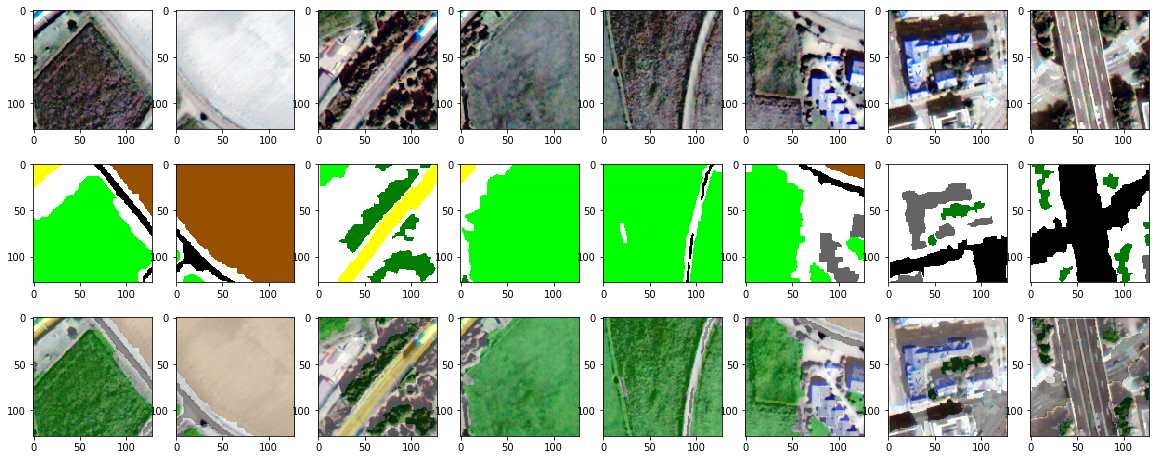

In [52]:
imgs_row = 8
fig, axes = plt.subplots(3,imgs_row)
fig.set_size_inches(20,8)
offset = 10
alpha=.3
for i in range(offset, offset + imgs_row):
    axes[0][i-offset].imshow(im_patches[i][:,:,:3])
    axes[1][i-offset].imshow(gt_label_to_color(gt_patches[i]))
    axes[2][i-offset].imshow(gt_label_to_color(gt_patches[i])*alpha+im_patches[i][:,:,:3]*(1-alpha))

[0. 1. 2. 3. 4. 5. 6. 7. 8.] [2098531  765495 1191470  460171  390497   45045  183389  103897    4385]


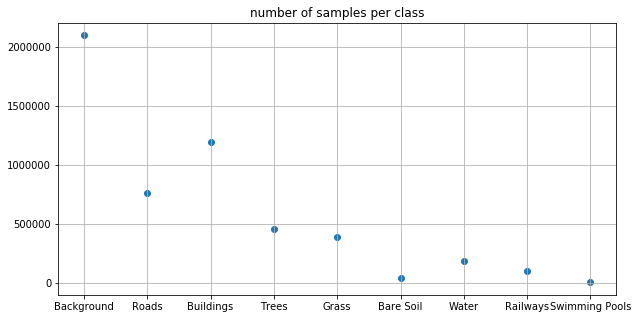

In [53]:
# print some statistics for the class distribution
unique, counts = np.unique(gt,return_counts=True)
print(unique, counts)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,5)
ax.scatter(unique,counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

# Keras test

In [54]:
np.random.seed(42)

from __future__ import print_function

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras import optimizers

from keras.utils import to_categorical
import keras.losses
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.callbacks import *

In [55]:
x_train, x_val, y_train_labels, y_val_labels  = train_test_split(im_patches, gt_patches, test_size=.2, random_state = 42)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train_labels.flatten()), y_train_labels.flatten())    
class_weights[0] = 0 # give less weight to background label class
class_weights[5] = 1 # give less weight to swimming pool class
class_weights[8] = 1 # give less weight to swimming pool class
print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f"%(names[i],w))

Class weights:
     Background: 0.000
          Roads: 0.770
      Buildings: 0.472
          Trees: 1.345
          Grass: 1.478
      Bare Soil: 1.000
          Water: 3.217
       Railways: 5.926
 Swimming Pools: 1.000


In [56]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)

# make y data categorical
y_train = to_categorical(y_train_labels, n_classes)
y_val = to_categorical(y_val_labels, n_classes)

In [57]:
# remove background class
y_train = y_train[:,:,:,1:]
y_val = y_val[:,:,:,1:]
n_classes = n_classes -1 

In [58]:
# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

(256, 128, 128, 4)
(256, 128, 128, 8)
(64, 128, 128, 4)
(64, 128, 128, 8)


## UNET

In [59]:
def get_unet(n_classes,input_shape=x_train.shape[1:]):
    """get UNET model instance"""
    
    inputs = Input(input_shape)

    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    conv1 = Dropout(.1)(conv1)
    conv1 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Dropout(.1)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Dropout(.1)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Dropout(.1)(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Dropout(.1)(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Dropout(.1)(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Dropout(.1)(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Dropout(.1)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (5, 5), activation='relu', padding='same')(up9)
    conv9 = Dropout(.1)(conv9)
    conv9 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='softmax')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    sgd = optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])

    return model

In [60]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

# callbacks (evaluated every epoch)
# keep track of the accuracy over epochs
callback_history = AccuracyHistory()

# stop early if after several epochs the accuracy doesn't improive
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto', 
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
filepath="weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

In [62]:
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    featurewise_center=True,              # Set input mean to 0 over the dataset, feature-wise.
    featurewise_std_normalization=True,   # Divide inputs by std of the dataset, feature-wise.
    #shear_range=0.2,
    #zoom_range=0.2,
    rotation_range=.5,
    horizontal_flip=True,
    vertical_flip=True)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

batch_size = 10
epochs = 500

def model_train(model, data_augmentation = True):
    if not data_augmentation:
        print('Not using data augmentation.')
        model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              class_weight = class_weights,
              validation_data = (x_val, y_val),
              callbacks=[callback_history, 
                         callback_earlystop, 
                         callback_lr,
                         callback_checkpoint])
    else:
        print('Using real-time data augmentation.')

        # Fit the model on the batches generated by datagen.flow().
        model.fit_generator(datagen.flow(x_train, y_train,
                                         batch_size=batch_size),
                            steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                            epochs=epochs,
                            verbose=1,
                            class_weight = class_weights, # weights for loss function
                            validation_data=(x_val, y_val),
                            callbacks=[callback_history, 
                                       callback_earlystop,
                                       callback_lr,
                                       callback_checkpoint],
                            workers=multiprocessing.cpu_count()-1,
                            use_multiprocessing=True)
        # TODO ignore background

# train the model
model = get_unet(n_classes)
#model.load_weights('weights-improvement.hdf5')
model_train(model, data_augmentation = False)
#model = load_model('model_unet_8cl.h5')

Not using data augmentation.
Train on 256 samples, validate on 64 samples
Epoch 1/500
256/256 [==============================] - 12s 47ms/step - loss: 1.1792 - acc: 0.3385 - val_loss: 1.0868 - val_acc: 0.2082
Epoch 2/500
256/256 [==============================] - 7s 28ms/step - loss: 0.9671 - acc: 0.2719 - val_loss: 1.0232 - val_acc: 0.2473
Epoch 3/500
256/256 [==============================] - 7s 26ms/step - loss: 0.9289 - acc: 0.2911 - val_loss: 1.0291 - val_acc: 0.1973
Epoch 4/500
256/256 [==============================] - 7s 26ms/step - loss: 0.9144 - acc: 0.2547 - val_loss: 1.0020 - val_acc: 0.1991
Epoch 5/500
256/256 [==============================] - 7s 26ms/step - loss: 0.9012 - acc: 0.2616 - val_loss: 0.9826 - val_acc: 0.2055
Epoch 6/500
256/256 [==============================] - 7s 28ms/step - loss: 0.8768 - acc: 0.2802 - val_loss: 0.9472 - val_acc: 0.2490
Epoch 7/500
256/256 [==============================] - 7s 26ms/step - loss: 0.8397 - acc: 0.3079 - val_loss: 0.9004 - val

256/256 [==============================] - 7s 26ms/step - loss: 0.5530 - acc: 0.4608 - val_loss: 0.6543 - val_acc: 0.4247
Epoch 62/500
256/256 [==============================] - 7s 26ms/step - loss: 0.5564 - acc: 0.4576 - val_loss: 0.6300 - val_acc: 0.4404
Epoch 63/500
256/256 [==============================] - 7s 26ms/step - loss: 0.5585 - acc: 0.4524 - val_loss: 0.6477 - val_acc: 0.4061
Epoch 64/500
256/256 [==============================] - 7s 26ms/step - loss: 0.5498 - acc: 0.4544 - val_loss: 0.6453 - val_acc: 0.4246
Epoch 65/500
256/256 [==============================] - 7s 26ms/step - loss: 0.5494 - acc: 0.4579 - val_loss: 0.6418 - val_acc: 0.4248
Epoch 66/500
256/256 [==============================] - 7s 26ms/step - loss: 0.5398 - acc: 0.4595 - val_loss: 0.6566 - val_acc: 0.4124
Epoch 67/500
256/256 [==============================] - 7s 26ms/step - loss: 0.5436 - acc: 0.4601 - val_loss: 0.6193 - val_acc: 0.4445
Epoch 68/500
256/256 [==============================] - 7s 26ms/step

256/256 [==============================] - 7s 26ms/step - loss: 0.4806 - acc: 0.5013 - val_loss: 0.5762 - val_acc: 0.4568
Epoch 122/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4783 - acc: 0.5063 - val_loss: 0.6362 - val_acc: 0.4059
Epoch 123/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4820 - acc: 0.5019 - val_loss: 0.5737 - val_acc: 0.4649
Epoch 124/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4811 - acc: 0.5048 - val_loss: 0.5755 - val_acc: 0.4753
Epoch 125/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4775 - acc: 0.5074 - val_loss: 0.5817 - val_acc: 0.4573
Epoch 126/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4842 - acc: 0.5015 - val_loss: 0.5745 - val_acc: 0.4644
Epoch 127/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4724 - acc: 0.5091 - val_loss: 0.5719 - val_acc: 0.4826
Epoch 128/500
256/256 [==============================] - 7s 26

256/256 [==============================] - 7s 26ms/step - loss: 0.4339 - acc: 0.5492 - val_loss: 0.5260 - val_acc: 0.5300
Epoch 182/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4365 - acc: 0.5489 - val_loss: 0.5072 - val_acc: 0.5060
Epoch 183/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4337 - acc: 0.5441 - val_loss: 0.5157 - val_acc: 0.4932
Epoch 184/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4333 - acc: 0.5426 - val_loss: 0.5092 - val_acc: 0.5243
Epoch 185/500
256/256 [==============================] - 7s 28ms/step - loss: 0.4311 - acc: 0.5456 - val_loss: 0.5192 - val_acc: 0.5391
Epoch 186/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4352 - acc: 0.5547 - val_loss: 0.5297 - val_acc: 0.5024
Epoch 187/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4311 - acc: 0.5493 - val_loss: 0.5260 - val_acc: 0.5155
Epoch 188/500
256/256 [==============================] - 7s 26

256/256 [==============================] - 7s 26ms/step - loss: 0.4051 - acc: 0.5658 - val_loss: 0.4944 - val_acc: 0.5215
Epoch 241/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4064 - acc: 0.5618 - val_loss: 0.4864 - val_acc: 0.5311
Epoch 242/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4144 - acc: 0.5627 - val_loss: 0.4975 - val_acc: 0.5137
Epoch 243/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4074 - acc: 0.5600 - val_loss: 0.4904 - val_acc: 0.5212
Epoch 244/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4029 - acc: 0.5688 - val_loss: 0.4829 - val_acc: 0.5441
Epoch 245/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4033 - acc: 0.5641 - val_loss: 0.4836 - val_acc: 0.5251
Epoch 246/500
256/256 [==============================] - 7s 26ms/step - loss: 0.4060 - acc: 0.5607 - val_loss: 0.4801 - val_acc: 0.5389
Epoch 247/500
256/256 [==============================] - 7s 26

256/256 [==============================] - 7s 26ms/step - loss: 0.3896 - acc: 0.5725 - val_loss: 0.4633 - val_acc: 0.5467
Epoch 301/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3869 - acc: 0.5772 - val_loss: 0.4799 - val_acc: 0.5398
Epoch 302/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3956 - acc: 0.5713 - val_loss: 0.4701 - val_acc: 0.5504
Epoch 303/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3869 - acc: 0.5739 - val_loss: 0.4749 - val_acc: 0.5397
Epoch 304/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3890 - acc: 0.5718 - val_loss: 0.4675 - val_acc: 0.5344
Epoch 305/500
250/256 [============================>.] - ETA: 0s - loss: 0.3864 - acc: 0.5722
Epoch 00305: reducing learning rate to 0.0002500000118743628.
256/256 [==============================] - 7s 28ms/step - loss: 0.3874 - acc: 0.5722 - val_loss: 0.4612 - val_acc: 0.5604
Epoch 306/500
256/256 [==============================] -

256/256 [==============================] - 7s 26ms/step - loss: 0.3715 - acc: 0.5821 - val_loss: 0.4487 - val_acc: 0.5513
Epoch 359/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3729 - acc: 0.5791 - val_loss: 0.4490 - val_acc: 0.5612
Epoch 360/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3718 - acc: 0.5875 - val_loss: 0.4506 - val_acc: 0.5469
Epoch 361/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3720 - acc: 0.5804 - val_loss: 0.4471 - val_acc: 0.5607
Epoch 362/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3703 - acc: 0.5856 - val_loss: 0.4503 - val_acc: 0.5424
Epoch 363/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3717 - acc: 0.5826 - val_loss: 0.4490 - val_acc: 0.5530
Epoch 364/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3709 - acc: 0.5759 - val_loss: 0.4443 - val_acc: 0.5589
Epoch 365/500
256/256 [==============================] - 7s 26

256/256 [==============================] - 7s 26ms/step - loss: 0.3672 - acc: 0.5873 - val_loss: 0.4424 - val_acc: 0.5555
Epoch 418/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3670 - acc: 0.5811 - val_loss: 0.4417 - val_acc: 0.5589
Epoch 419/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3681 - acc: 0.5894 - val_loss: 0.4422 - val_acc: 0.5568
Epoch 420/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3665 - acc: 0.5802 - val_loss: 0.4447 - val_acc: 0.5563
Epoch 421/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3666 - acc: 0.5849 - val_loss: 0.4411 - val_acc: 0.5593
Epoch 422/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3661 - acc: 0.5817 - val_loss: 0.4411 - val_acc: 0.5591
Epoch 423/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3670 - acc: 0.5866 - val_loss: 0.4421 - val_acc: 0.5621
Epoch 424/500
256/256 [==============================] - 7s 26

256/256 [==============================] - 7s 26ms/step - loss: 0.3639 - acc: 0.5873 - val_loss: 0.4399 - val_acc: 0.5596
Epoch 477/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3640 - acc: 0.5862 - val_loss: 0.4398 - val_acc: 0.5603
Epoch 478/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3640 - acc: 0.5858 - val_loss: 0.4389 - val_acc: 0.5604
Epoch 479/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3636 - acc: 0.5838 - val_loss: 0.4392 - val_acc: 0.5593
Epoch 480/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3639 - acc: 0.5866 - val_loss: 0.4394 - val_acc: 0.5603
Epoch 481/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3639 - acc: 0.5863 - val_loss: 0.4393 - val_acc: 0.5610
Epoch 482/500
256/256 [==============================] - 7s 26ms/step - loss: 0.3635 - acc: 0.5877 - val_loss: 0.4399 - val_acc: 0.5596
Epoch 483/500
256/256 [==============================] - 7s 26

In [68]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

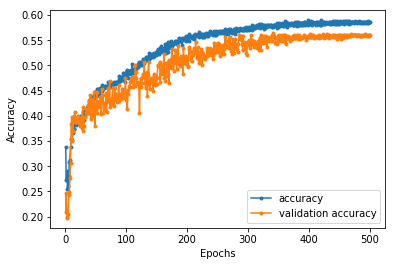

In [69]:
# Plot accuracy evolution over epochs
def plot_train_model(epochs):
    plt.plot(range(1,epochs+1), callback_history.acc, '.-', range(1,epochs+1), callback_history.val_acc, '.-')
    plt.xlabel('Epochs', )
    plt.ylabel('Accuracy')
    plt.legend(['accuracy', 'validation accuracy'])
    plt.show()

plot_train_model(epochs)

# Prediction

In [70]:
# save the model
model.save('model_unet_128.h5')  # save model, weights
#model.load('model_unet.h5')

In [71]:
score = model.evaluate(x_val, y_val, batch_size = 1, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4386343617225066
Test accuracy: 0.5613861083984375


In [72]:
y_pred = model.predict(x_val, batch_size = 5, verbose = 1)
y_pred_label = np.argmax(y_pred,axis=-1)+1

64/64 [==============================] - 1s 17ms/step


In [73]:
# Get accuracy as margin between highest and second highest class
y_pred_rank = np.sort(y_pred,axis=-1) # for every pixel, get the rank
y_pred_max1 = y_pred_rank[:,:,:,-1] # second highest proba
y_pred_max2 = y_pred_rank[:,:,:,-2] # second highest proba
y_pred_acc = y_pred_max1 - y_pred_max2

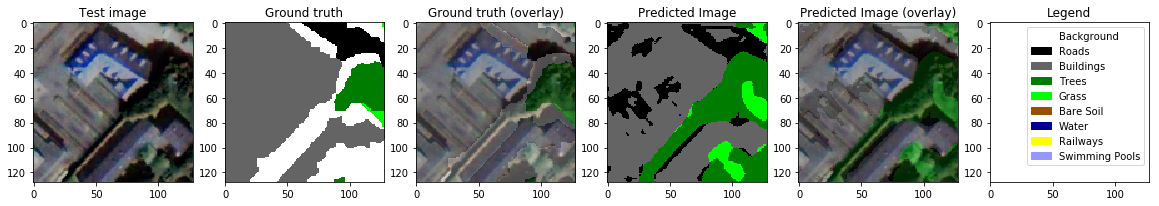

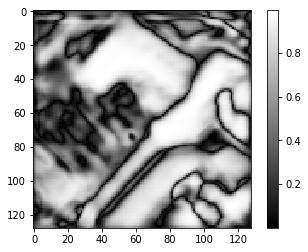

In [76]:
# plot prediction results
im_idx = 5
alpha = .3 # for overlay
fig, axes = plt.subplots(1,6)
fig.set_size_inches(20,20)
fig_im = x_val[im_idx][:,:,:3]*(1-alpha)
fig_val = gt_label_to_color(y_val_labels[im_idx])
fig_pred = gt_label_to_color(y_pred_label[im_idx])

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_val)
axes[2].imshow(fig_val*alpha+fig_im*(1-alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred*alpha+fig_im*(1-alpha))
axes[5].imshow(fig_im*0+1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0],l[1]] for l in legend.items()]
handles = [Rectangle((0,0),1,1, color = (v/255 for v in c)) for n,c in legend_data]
labels = [n for n,c in legend_data]
axes[5].legend(handles,labels)

# show certitude by network
fig = plt.figure()
plt.imshow(y_pred_acc[im_idx], cmap='gray')
plt.colorbar()

# Accuracy metrics

In [77]:
# Validation accuracy
# mask background class for evaluation
print("Validation accuracy: %.3f" % sklearn.metrics.accuracy_score(y_pred_label[y_val_labels!=0].flatten(),y_val_labels[y_val_labels!=0].flatten()))
print(sklearn.metrics.classification_report(y_pred_label[y_val_labels!=0].flatten(),y_val_labels[y_val_labels!=0].flatten(),target_names=labels[1:]))

Validation accuracy: 0.729
                precision    recall  f1-score   support

         Roads       0.73      0.67      0.70    175052
     Buildings       0.82      0.69      0.75    242016
         Trees       0.87      0.85      0.86    116018
         Grass       0.70      0.75      0.73     70195
     Bare Soil       0.29      0.86      0.43      5496
         Water       0.59      0.93      0.72     24393
      Railways       0.00      0.00      0.00         0
Swimming Pools       0.00      0.00      0.00         5

   avg / total       0.78      0.73      0.75    633175



# Certainty using Density Forest

In [78]:
# from https://github.com/keras-team/keras/issues/41
from keras import backend as K

def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return np.asarray(activations[0])

activations = get_activations(model, -2, x_val)

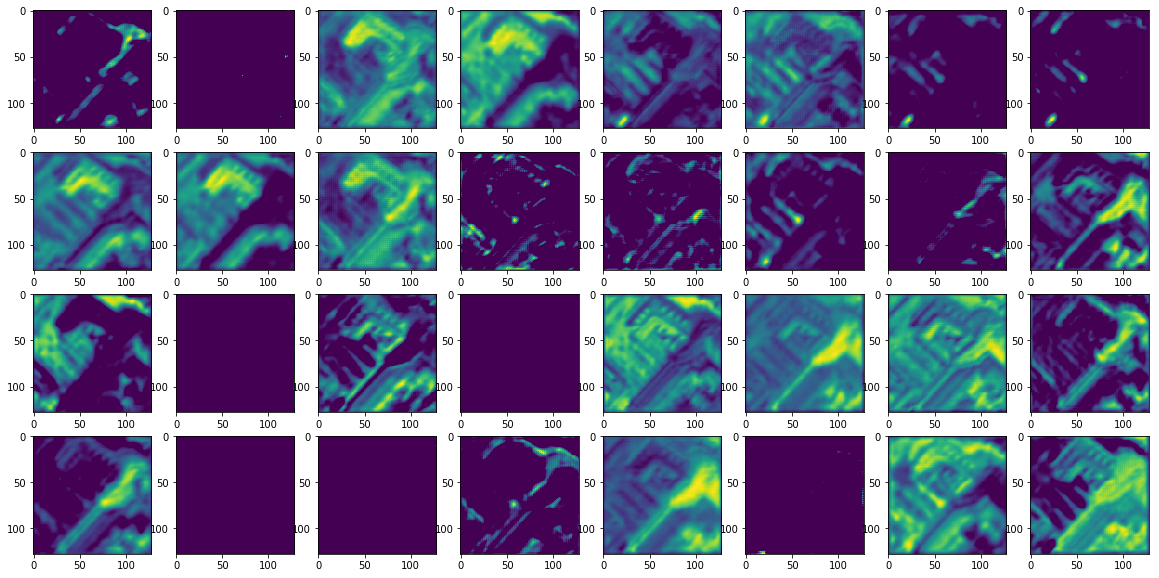

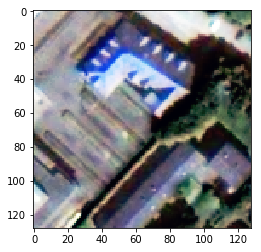

In [79]:
# visualize some activations
fig, axes = plt.subplots(4,8)
fig.set_size_inches(20,10)
for i in range(4):
    for j in range(8):
        axes[i][j].imshow(activations[im_idx][:,:,i*8+j])
plt.show()

plt.figure()
plt.imshow(x_val[im_idx][:,:,:3])
plt.show()

# Density Forest Uncertainty Measure
Feed activation weigths into density tree

In [80]:
import sys
sys.path.append('/home/cyrilwendl/SIE-Master/Code') # Path to density Tree package
sys.path.append('/home/cyrilwendl/SIE-Master/Code/density_tree') # Path to density Tree package

from density_tree import density_tree
from density_tree.density_forest import *
from density_tree.density_tree_create import create_density_tree
from sklearn import decomposition
import warnings

In [81]:
activations_2D = np.reshape(activations, (activations.shape[0]*activations.shape[1]*activations.shape[2],activations.shape[3]))

Explained variance ratio by first components:
[0.56830933 0.2081067  0.10132576 0.05001645 0.0275832 ]
Variance explained by first 5 components: 0.96


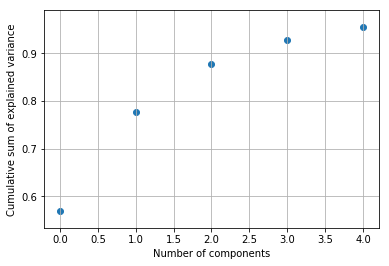

In [83]:
# create density tree for activation weights of training data

dimensions = np.shape(activations_2D)[-1]

# PCA
n_components = 5
plt.cla()
pca = decomposition.PCA(n_components=n_components)
pca.fit(activations_2D)
print("Explained variance ratio by first components:")
print(pca.explained_variance_ratio_)  
print("Variance explained by first %i components: %.2f" % (n_components, np.sum(pca.explained_variance_ratio_[:n_components])))
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
#plt.savefig("../Figures/pca_components.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [84]:
X_all = pca.transform(activations_2D)
#X_seen = pca.transform(activations_seen_classes)
#X_unseen = pca.transform(activations_unseen_class)

y_val_1D = np.reshape(y_val_labels,(y_val_labels.shape[0]*y_val_labels.shape[1]*y_val_labels.shape[2]))

In [91]:
n_points = 1000
dataset_indices = np.arange(len(X_all))

#  draw random samples with replacement
dataset_subset_indices = np.random.choice(dataset_indices, size=n_points, replace=True,)
dataset_subset = X_all[dataset_subset_indices, :]

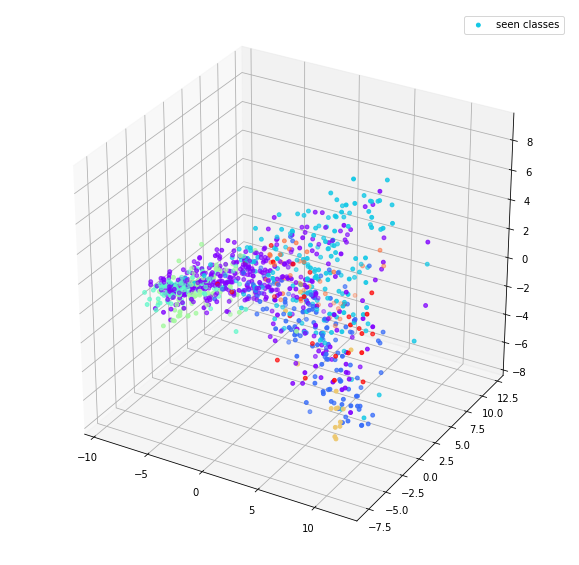

In [92]:
# for interactive Jupyter Notebook
# %matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_all[dataset_subset_indices,0], X_all[dataset_subset_indices,1], zs=X_all[dataset_subset_indices,2], c=y_val_1D[dataset_subset_indices], cmap=plt.get_cmap('rainbow'), s=15)
#ax.scatter(X_unseen[:,0], X_unseen[:,1], zs=X_unseen[:,2], c='black', s=30, marker='x', depthshade=False) 
ax.legend(['seen classes','unseen class'])

#plt.savefig("../Figures/pca_components_3d.pdf", bbox_inches='tight', pad_inches=0)
#plt.show()

In [93]:
print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

Variance explained by first 3 components: 0.88


In [94]:
warnings.filterwarnings("ignore")
#root = create_density_tree(X_all, dimensions = n_components, clusters = n_classes, verbose = True)

In [95]:
warnings.filterwarnings("ignore")
subset_data = 0.001
print("Number of points on which to train trees: %i" % int(np.shape(X_all)[0] * subset_data))
root_nodes_seen = density_forest_create(X_all, n_components, n_classes, 50, subset_data, -1)

Number of points on which to train trees: 1048


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:   14.2s finished


In [97]:
# get probabilities for one image
probas_seen = density_forest_traverse(X_all[im_idx*(patch_size * patch_size):(im_idx+1)*(patch_size * patch_size),:], root_nodes_seen, -1)

[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 852 tasks      | elapsed:   29.1s
[Parallel(n_jobs=8)]: Done 1552 tasks      | elapsed:   51.7s
[Parallel(n_jobs=8)]: Done 2452 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 3552 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 4852 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 6352 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 8052 tasks      | elapsed:  4.6min
[Parallel(n_jobs=8)]: Done 9952 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 12052 tasks      | elapsed:  7.0min
[Parallel(n_jobs=8)]: Done 13498 tasks      | elapsed:  8.4min
[Parallel(n_jobs=8)]: Done 14748 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 16098 tasks      | elapsed: 11.5min
[Parallel(n_jobs=8)]: Done 16384 out of 16384 | elapsed: 11.8min finished


In [98]:
probas_seen[np.isnan(probas_seen)] = -np.infty
probas_seen_notnan = probas_seen # only keep non-NaN values
probas_seen_im = np.reshape(probas_seen_notnan, (patch_size,patch_size))

In [99]:
#ad-hoc scaling of probabilities
probas_seen_im = probas_seen_im/np.max(probas_seen_im)

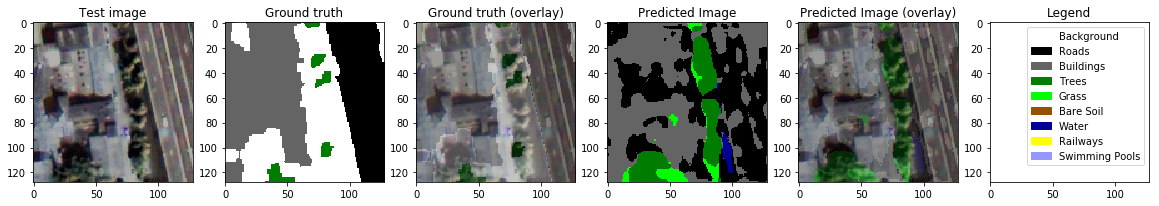

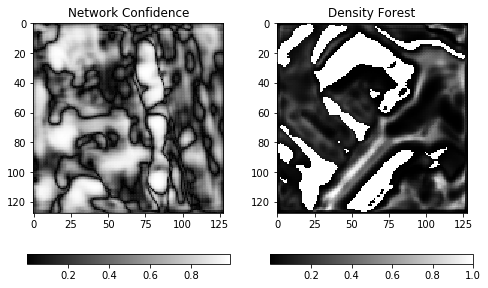

In [101]:
# plot prediction results with new uncertainty
# %matplotlib inline
im_idx = 2
alpha = .3 # for overlay
fig, axes = plt.subplots(1,6)
fig.set_size_inches(20,20)
fig_im = x_val[im_idx][:,:,:3]*(1-alpha)
fig_val = gt_label_to_color(y_val_labels[im_idx])
fig_pred = gt_label_to_color(y_pred_label[im_idx])

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_val)
axes[2].imshow(fig_val*alpha+fig_im*(1-alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred*alpha+fig_im*(1-alpha))
axes[5].imshow(fig_im*0+1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0],l[1]] for l in legend.items()]
handles = [Rectangle((0,0),1,1, color = (v/255 for v in c)) for n,c in legend_data]
labels = [n for n,c in legend_data]
axes[5].legend(handles,labels)

# show certitude by network
fig, axes = plt.subplots(1,2)
fig.set_size_inches(8,5)
f1 = axes[0].imshow(y_pred_acc[im_idx], cmap='gray')
fig.colorbar(f1, ax=axes[0], orientation='horizontal')
f2 = axes[1].imshow(probas_seen_im, cmap='gray')
fig.colorbar(f2, ax=axes[1], orientation='horizontal',spacing='proportional')
axes[0].set_title("Network Confidence")
axes[1].set_title("Density Forest")
plt.show()